# Pix2Pix实现图像转换

## Pix2Pix概述

Pix2Pix是基于条件生成对抗网络（cGAN, Condition Generative Adversarial Networks ）实现的一种深度学习图像转换模型，该模型是由Phillip Isola等作者在2017年CVPR上提出的，可以实现语义/标签到真实图片、灰度图到彩色图、航空图到地图、白天到黑夜、线稿图到实物图的转换。Pix2Pix是将cGAN应用于有监督的图像到图像翻译的经典之作，其包括两个模型：**生成器**和**判别器**。

传统上，尽管此类任务的目标都是相同的从像素预测像素，但每项都是用单独的专用机器来处理的。而Pix2Pix使用的网络作为一个通用框架，使用相同的架构和目标，只在不同的数据上进行训练，即可得到令人满意的结果，鉴于此许多人已经使用此网络发布了他们自己的艺术作品。

## 基础原理

cGAN的生成器与传统GAN的生成器在原理上有一些区别，cGAN的生成器是将输入图片作为指导信息，由输入图像不断尝试生成用于迷惑判别器的“假”图像，由输入图像转换输出为相应“假”图像的本质是从像素到另一个像素的映射，而传统GAN的生成器是基于一个给定的随机噪声生成图像，输出图像通过其他约束条件控制生成，这是cGAN和GAN的在图像翻译任务中的差异。Pix2Pix中判别器的任务是判断从生成器输出的图像是真实的训练图像还是生成的“假”图像。在生成器与判别器的不断博弈过程中，模型会达到一个平衡点，生成器输出的图像与真实训练数据使得判别器刚好具有50%的概率判断正确。

在案例开始前，首先定义一些在整个过程中需要用到的符号：

- $x$：代表观测图像的数据。
- $z$：代表随机噪声的数据。
- $y=G(x,z)$：生成器网络，给出由观测图像$x$与随机噪声$z$生成的“假”图片，其中$x$来自于训练数据而非生成器。
- $D(x,G(x,z))$：判别器网络，给出图像判定为真实图像的概率，其中$x$来自于训练数据，$G(x,z)$来自于生成器。

cGAN的目标可以表示为：

$$L_{cGAN}(G,D)=E_{(x,y)}[log(D(x,y))]+E_{(x,z)}[log(1-D(x,G(x,z)))]$$

该公式是cGAN的损失函数，`D`想要尽最大努力去正确分类真实图像与“假”图像，也就是使参数$log D(x,y)$最大化；而`G`则尽最大努力用生成的“假”图像$y$欺骗`D`，避免被识破，也就是使参数$log(1−D(G(x,z)))$最小化。cGAN的目标可简化为：

$$arg\min_{G}\max_{D}L_{cGAN}(G,D)$$

![pix2pix1](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.0/tutorials/application/source_zh_cn/generative/images/pix2pix_1.png)

为了对比cGAN和GAN的不同，我们将GAN的目标也进行了说明：

$$L_{GAN}(G,D)=E_{y}[log(D(y))]+E_{(x,z)}[log(1-D(x,z))]$$

从公式可以看出，GAN直接由随机噪声$z$生成“假”图像，不借助观测图像$x$的任何信息。过去的经验告诉我们，GAN与传统损失混合使用是有好处的，判别器的任务不变，依旧是区分真实图像与“假”图像，但是生成器的任务不仅要欺骗判别器，还要在传统损失的基础上接近训练数据。假设cGAN与L1正则化混合使用，那么有:

$$L_{L1}(G)=E_{(x,y,z)}[||y-G(x,z)||_{1}]$$

进而得到最终目标：

$$arg\min_{G}\max_{D}L_{cGAN}(G,D)+\lambda L_{L1}(G)$$

图像转换问题本质上其实就是像素到像素的映射问题，Pix2Pix使用完全一样的网络结构和目标函数，仅更换不同的训练数据集就能分别实现以上的任务。


## 设置运行环境

具体设置如下参数：

 ascend_config={"precision_mode":"allow_mix_precision"} : 自动混合精度，自动将部分算子的精度降低到float16或bfloat16。

In [1]:
import mindspore
mindspore.set_context(ascend_config={"precision_mode":"allow_mix_precision"})

/home/HwHiAiUser/.conda/envs/mindspore2.6_py39/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/HwHiAiUser/.conda/envs/mindspore2.6_py39/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/HwHiAiUser/.conda/envs/mindspore2.6_py39/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/HwHiAiUser/.conda/envs/mindspore2.6_py39/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
[WARNING] 

## 创建网络

当处理完数据后，就可以来进行网络的搭建了。网络搭建将逐一详细讨论生成器、判别器和损失函数。生成器G用到的是U-Net结构，输入的轮廓图$x$编码再解码成真是图片，判别器D用到的是作者自己提出来的条件判别器PatchGAN，判别器D的作用是在轮廓图 $x$的条件下，对于生成的图片$G(x)$判断为假，对于真实判断为真。

### 生成器G结构

U-Net是德国Freiburg大学模式识别和图像处理组提出的一种全卷积结构。它分为两个部分，其中左侧是由卷积和降采样操作组成的压缩路径，右侧是由卷积和上采样组成的扩张路径，扩张的每个网络块的输入由上一层上采样的特征和压缩路径部分的特征拼接而成。网络模型整体是一个U形的结构，因此被叫做U-Net。和常见的先降采样到低维度，再升采样到原始分辨率的编解码结构的网络相比，U-Net的区别是加入skip-connection，对应的feature maps和decode之后的同样大小的feature maps按通道拼一起，用来保留不同分辨率下像素级的细节信息。

![pix2pix2](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.0/tutorials/application/source_zh_cn/generative/images/pix2pix_2.png)

#### 定义UNet Skip Connection Block

In [31]:
import mindspore.nn as nn
import mindspore.ops as ops
import mindspore.mint.nn as mint_nn
import time
import mindspore as ms
import mindspore.mint.nn.functional as mint_f  # 导入mint函数式接口
a1 = time.time()

# 自定义层：包裹mint的functional.leaky_relu，模拟层接口
class MintLeakyReLU(nn.Cell):
    def __init__(self, negative_slope=0.2):
        """
        Args:
            negative_slope: 负斜率，默认0.2
        """
        super().__init__()
        self.negative_slope = negative_slope  # 保存负斜率参数

    def construct(self, x):
        # 调用mint函数式接口
        return mint_f.leaky_relu(x, negative_slope=self.negative_slope)
class UNetSkipConnectionBlock(nn.Cell):
    def __init__(self, outer_nc, inner_nc, in_planes=None, dropout=False,
                 submodule=None, outermost=False, innermost=False, alpha=0.2, norm_mode='batch'):
        super(UNetSkipConnectionBlock, self).__init__()
        down_norm = nn.BatchNorm2d(inner_nc)
        up_norm = nn.BatchNorm2d(outer_nc)
        use_bias = False
        if norm_mode == 'instance':
            down_norm = nn.BatchNorm2d(inner_nc, affine=False)
            up_norm = nn.BatchNorm2d(outer_nc, affine=False)
            use_bias = True
        if in_planes is None:
            in_planes = outer_nc
        down_conv = nn.Conv2d(in_planes, inner_nc, kernel_size=4,
                              stride=2, padding=1, has_bias=use_bias, pad_mode='pad')
        down_relu = MintLeakyReLU(negative_slope=alpha)
        up_relu = mint_nn.ReLU()
        if outermost:
            up_conv = nn.Conv2dTranspose(inner_nc * 2, outer_nc,
                                         kernel_size=4, stride=2,
                                         padding=1, pad_mode='pad')
            down = [down_conv]
            up = [up_relu, up_conv, mint_nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            up_conv = nn.Conv2dTranspose(inner_nc, outer_nc,
                                         kernel_size=4, stride=2,
                                         padding=1, has_bias=use_bias, pad_mode='pad')
            down = [down_relu, down_conv]
            up = [up_relu, up_conv, up_norm]
            model = down + up
        else:
            up_conv = nn.Conv2dTranspose(inner_nc * 2, outer_nc,
                                         kernel_size=4, stride=2,
                                         padding=1, has_bias=use_bias, pad_mode='pad')
            down = [down_relu, down_conv, down_norm]
            up = [up_relu, up_conv, up_norm]

            model = down + [submodule] + up
            if dropout:
                model.append(mint_nn.Dropout(p=0.5))
        self.model = nn.SequentialCell(model)
        self.skip_connections = not outermost

    def construct(self, x):
        out = self.model(x)
        if self.skip_connections:
            out = ops.concat((out, x), axis=1)
        return out

#### 基于UNet的生成器

In [3]:
class UNetGenerator(nn.Cell):
    def __init__(self, in_planes, out_planes, ngf=64, n_layers=8, norm_mode='bn', dropout=False):
        super(UNetGenerator, self).__init__()
        unet_block = UNetSkipConnectionBlock(ngf * 8, ngf * 8, in_planes=None, submodule=None,
                                             norm_mode=norm_mode, innermost=True)
        for _ in range(n_layers - 5):
            unet_block = UNetSkipConnectionBlock(ngf * 8, ngf * 8, in_planes=None, submodule=unet_block,
                                                 norm_mode=norm_mode, dropout=dropout)
        unet_block = UNetSkipConnectionBlock(ngf * 4, ngf * 8, in_planes=None, submodule=unet_block,
                                             norm_mode=norm_mode)
        unet_block = UNetSkipConnectionBlock(ngf * 2, ngf * 4, in_planes=None, submodule=unet_block,
                                             norm_mode=norm_mode)
        unet_block = UNetSkipConnectionBlock(ngf, ngf * 2, in_planes=None, submodule=unet_block,
                                             norm_mode=norm_mode)
        self.model = UNetSkipConnectionBlock(out_planes, ngf, in_planes=in_planes, submodule=unet_block,
                                             outermost=True, norm_mode=norm_mode)

    def construct(self, x):
        return self.model(x)

原始cGAN的输入是条件x和噪声z两种信息，这里的生成器只使用了条件信息，因此不能生成多样性的结果。因此Pix2Pix在训练和测试时都使用了dropout，这样可以生成多样性的结果。

### 基于PatchGAN的判别器

判别器使用的PatchGAN结构，可看做卷积。生成的矩阵中的每个点代表原图的一小块区域（patch）。通过矩阵中的各个值来判断原图中对应每个Patch的真假。

In [11]:
import mindspore.nn as nn

class ConvNormRelu(nn.Cell):
    def __init__(self,
                 in_planes,
                 out_planes,
                 kernel_size=4,
                 stride=2,
                 alpha=0.2,
                 norm_mode='batch',
                 pad_mode='CONSTANT',
                 use_relu=True,
                 padding=None):
        super(ConvNormRelu, self).__init__()
        norm = mint_nn.BatchNorm2d(out_planes)
        if norm_mode == 'instance':
            norm = mint_nn.BatchNorm2d(out_planes, affine=False)
        has_bias = (norm_mode == 'instance')
        if not padding:
            padding = (kernel_size - 1) // 2
        if pad_mode == 'CONSTANT':
            conv = nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding_mode='zeros',
                             bias=has_bias, padding=padding)
            layers = [conv, norm]
        else:
            paddings = ((0, 0), (0, 0), (padding, padding), (padding, padding))
            pad = nn.Pad(paddings=paddings, mode=pad_mode)
            conv = nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding_mode='zeros', bias=has_bias)
            layers = [pad, conv, norm]
        if use_relu:
            relu = mint_nn.ReLU()
            if alpha > 0:
                relu = mint_nn.LeakyReLU(alpha=alpha)
            layers.append(relu)
        self.features = nn.SequentialCell(layers)

    def construct(self, x):
        output = self.features(x)
        return output


### Pix2Pix的生成器初始化


In [32]:
import mindspore.nn as nn
import mindspore.mint.nn as mint_nn  # 确保已导入mint_nn
from mindspore.common import initializer as init

g_in_planes = 3
g_out_planes = 3
g_ngf = 64
g_layers = 8
d_in_planes = 6
d_ndf = 64
d_layers = 3
alpha = 0.2
init_gain = 0.02
init_type = 'normal'

# 1. 初始化生成器
net_generator = UNetGenerator(
    in_planes=g_in_planes, 
    out_planes=g_out_planes,
    ngf=g_ngf, 
    n_layers=g_layers
)
print("✅ UNetGenerator初始化成功！")

# 2. 权重初始化
for _, cell in net_generator.cells_and_names():
    # 处理卷积层
    if isinstance(cell, (nn.Conv2d, nn.Conv2dTranspose)):
        if init_type == 'normal':
            cell.weight.set_data(init.initializer(init.Normal(init_gain), cell.weight.shape))
        elif init_type == 'xavier':
            cell.weight.set_data(init.initializer(init.XavierUniform(init_gain), cell.weight.shape))
        elif init_type == 'constant':
            cell.weight.set_data(init.initializer(0.001, cell.weight.shape))
        else:
            raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
    
    # 修复：处理mint_nn.BatchNorm2d（gamma→weight，beta→bias）
    elif isinstance(cell, mint_nn.BatchNorm2d):
        # 原cell.gamma（缩放参数）→ 现在用cell.weight
        cell.weight.set_data(init.initializer('ones', cell.weight.shape))
        # 原cell.beta（偏移参数）→ 现在用cell.bias
        cell.bias.set_data(init.initializer('zeros', cell.bias.shape))

print("✅ 生成器权重初始化成功！")

✅ UNetGenerator初始化成功！
✅ 生成器权重初始化成功！


## 准备环节

### 准备数据

在本案例中，我们将使用[指定数据集](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/models/application/dataset_pix2pix.tar)，该数据集是已经经过处理的外墙（facades）数据，可以直接使用mindspore.dataset的方法读取。

In [6]:
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/models/application/dataset_pix2pix.tar"

download(url, "./dataset", kind="tar", replace=True)


file_sizes: 100%|████████████████████████████| 881M/881M [03:06<00:00, 4.73MB/s]
Extracting tar file...
Successfully downloaded / unzipped to ./dataset


'./dataset'

### 数据展示

调用`Pix2PixDataset`和`create_train_dataset`读取训练集，这里我们直接下载已经处理好的数据集。

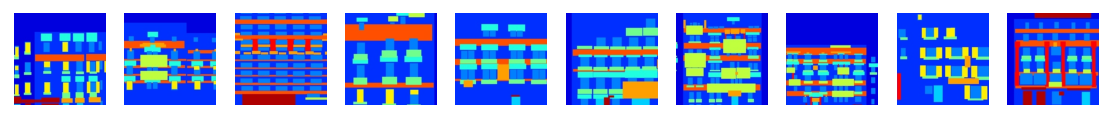

In [18]:
from mindspore import dataset as ds
import matplotlib.pyplot as plt

dataset = ds.MindDataset("./dataset/dataset_pix2pix/train.mindrecord", columns_list=["input_images", "target_images"], shuffle=True)
data_iter = next(dataset.create_dict_iterator(output_numpy=True))
# 可视化部分训练数据
plt.figure(figsize=(10, 3), dpi=140)
for i, image in enumerate(data_iter['input_images'][:10], 1):
    plt.subplot(3, 10, i)
    plt.axis("off")
    plt.imshow((image.transpose(1, 2, 0) + 1) / 2)
plt.show()

## 推理

通过load_checkpoint和load_param_into_net将ckpt中的权重参数导入到模型中，获取数据进行推理并对推理的效果图进行演示。

✅ 权重文件 './ckptGenerator_100.ckpt' 已存在，跳过下载！


[WARNING] ME(10025:255085688516640,MainProcess):2025-10-14-09:29:55.253.675 [mindspore/train/serialization.py:1770] For 'load_param_into_net', 52 parameters in the 'net' are not loaded, because they are not in the 'parameter_dict', please check whether the network structure is consistent when training and loading checkpoint.
[WARNING] ME(10025:255085688516640,MainProcess):2025-10-14-09:29:55.254.941 [mindspore/train/serialization.py:1774] ['model.model.1.model.2.moving_mean', 'model.model.1.model.2.moving_variance', 'model.model.1.model.2.gamma', 'model.model.1.model.2.beta', 'model.model.1.model.3.model.2.moving_mean', 'model.model.1.model.3.model.2.moving_variance', 'model.model.1.model.3.model.2.gamma', 'model.model.1.model.3.model.2.beta', 'model.model.1.model.3.model.3.model.2.moving_mean', 'model.model.1.model.3.model.3.model.2.moving_variance', 'model.model.1.model.3.model.3.model.2.gamma', 'model.model.1.model.3.model.3.model.2.beta', 'model.model.1.model.3.model.3.model.3.mode

✅ 权重已成功加载到网络！
.

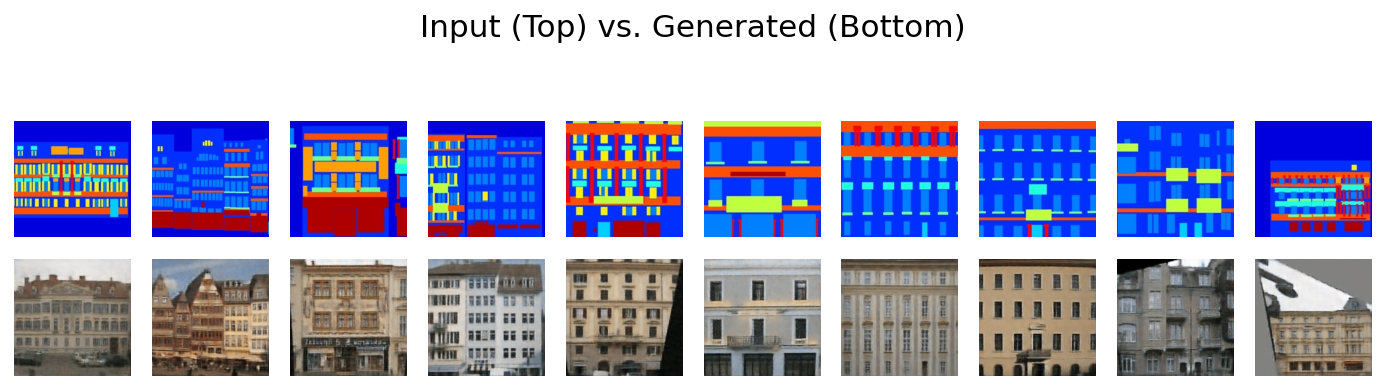

time: 19.29 seconds


In [33]:
import os  # 新增：导入os模块用于文件存在性判断
from mindspore import load_checkpoint, load_param_into_net, Tensor

def create_param_name_map():
    """
    创建一个从预训练权重参数名（gamma/beta）到当前网络参数名（weight/bias）的映射表。
    """
    param_map = {}
    # 第1组参数映射
    param_map["model.model.1.model.2.gamma"] = "model.model.1.model.2.weight"
    param_map["model.model.1.model.2.beta"] = "model.model.1.model.2.bias"
    param_map["model.model.1.model.2.moving_mean"] = "model.model.1.model.2.running_mean"
    param_map["model.model.1.model.2.moving_variance"] = "model.model.1.model.2.running_var"
    # 第2组参数映射
    param_map["model.model.1.model.3.model.2.gamma"] = "model.model.1.model.3.model.2.weight"
    param_map["model.model.1.model.3.model.2.beta"] = "model.model.1.model.3.model.2.bias"
    param_map["model.model.1.model.3.model.2.moving_mean"] = "model.model.1.model.3.model.2.running_mean"
    param_map["model.model.1.model.3.model.2.moving_variance"] = "model.model.1.model.3.model.2.running_var"
    # 第3组参数映射
    param_map["model.model.1.model.3.model.3.model.2.gamma"] = "model.model.1.model.3.model.3.model.2.weight"
    param_map["model.model.1.model.3.model.3.model.2.beta"] = "model.model.1.model.3.model.3.model.2.bias"
    param_map["model.model.1.model.3.model.3.model.2.moving_mean"] = "model.model.1.model.3.model.3.model.2.running_mean"
    param_map["model.model.1.model.3.model.3.model.2.moving_variance"] = "model.model.1.model.3.model.3.model.2.running_var"
    # 第4组参数映射
    param_map["model.model.1.model.3.model.3.model.3.model.2.gamma"] = "model.model.1.model.3.model.3.model.3.model.2.weight"
    param_map["model.model.1.model.3.model.3.model.3.model.2.beta"] = "model.model.1.model.3.model.3.model.3.model.2.bias"
    param_map["model.model.1.model.3.model.3.model.3.model.2.moving_mean"] = "model.model.1.model.3.model.3.model.3.model.2.running_mean"
    param_map["model.model.1.model.3.model.3.model.3.model.2.moving_variance"] = "model.model.1.model.3.model.3.model.3.model.2.running_var"
    # 第5组参数映射
    param_map["model.model.1.model.3.model.3.model.3.model.3.model.2.gamma"] = "model.model.1.model.3.model.3.model.3.model.3.model.2.weight"
    param_map["model.model.1.model.3.model.3.model.3.model.3.model.2.beta"] = "model.model.1.model.3.model.3.model.3.model.3.model.2.bias"
    param_map["model.model.1.model.3.model.3.model.3.model.3.model.2.moving_mean"] = "model.model.1.model.3.model.3.model.3.model.3.model.2.running_mean"
    param_map["model.model.1.model.3.model.3.model.3.model.3.model.2.moving_variance"] = "model.model.1.model.3.model.3.model.3.model.3.model.2.running_var"
    # 第6组参数映射
    param_map["model.model.1.model.3.model.3.model.3.model.3.model.3.model.2.gamma"] = "model.model.1.model.3.model.3.model.3.model.3.model.3.model.2.weight"
    param_map["model.model.1.model.3.model.3.model.3.model.3.model.3.model.2.beta"] = "model.model.1.model.3.model.3.model.3.model.3.model.3.model.2.bias"
    param_map["model.model.1.model.3.model.3.model.3.model.3.model.3.model.2.moving_mean"] = "model.model.1.model.3.model.3.model.3.model.3.model.3.model.2.running_mean"
    param_map["model.model.1.model.3.model.3.model.3.model.3.model.3.model.2.moving_variance"] = "model.model.1.model.3.model.3.model.3.model.3.model.3.model.2.running_var"
    # 第7组参数映射
    param_map["model.model.1.model.3.model.3.model.3.model.3.model.3.model.3.model.4.gamma"] = "model.model.1.model.3.model.3.model.3.model.3.model.3.model.3.model.4.weight"
    param_map["model.model.1.model.3.model.3.model.3.model.3.model.3.model.3.model.4.beta"] = "model.model.1.model.3.model.3.model.3.model.3.model.3.model.3.model.4.bias"
    param_map["model.model.1.model.3.model.3.model.3.model.3.model.3.model.3.model.4.moving_mean"] = "model.model.1.model.3.model.3.model.3.model.3.model.3.model.3.model.4.running_mean"
    param_map["model.model.1.model.3.model.3.model.3.model.3.model.3.model.3.model.4.moving_variance"] = "model.model.1.model.3.model.3.model.3.model.3.model.3.model.3.model.4.running_var"
    # 第8组参数映射
    param_map["model.model.1.model.3.model.3.model.3.model.3.model.3.model.6.gamma"] = "model.model.1.model.3.model.3.model.3.model.3.model.3.model.6.weight"
    param_map["model.model.1.model.3.model.3.model.3.model.3.model.3.model.6.beta"] = "model.model.1.model.3.model.3.model.3.model.3.model.3.model.6.bias"
    param_map["model.model.1.model.3.model.3.model.3.model.3.model.3.model.6.moving_mean"] = "model.model.1.model.3.model.3.model.3.model.3.model.3.model.6.running_mean"
    param_map["model.model.1.model.3.model.3.model.3.model.3.model.3.model.6.moving_variance"] = "model.model.1.model.3.model.3.model.3.model.3.model.3.model.6.running_var"
    # 第9组参数映射
    param_map["model.model.1.model.3.model.3.model.3.model.3.model.6.gamma"] = "model.model.1.model.3.model.3.model.3.model.3.model.6.weight"
    param_map["model.model.1.model.3.model.3.model.3.model.3.model.6.beta"] = "model.model.1.model.3.model.3.model.3.model.3.model.6.bias"
    param_map["model.model.1.model.3.model.3.model.3.model.3.model.6.moving_mean"] = "model.model.1.model.3.model.3.model.3.model.3.model.6.running_mean"
    param_map["model.model.1.model.3.model.3.model.3.model.3.model.6.moving_variance"] = "model.model.1.model.3.model.3.model.3.model.3.model.6.running_var"
    # 第10组参数映射
    param_map["model.model.1.model.3.model.3.model.3.model.6.gamma"] = "model.model.1.model.3.model.3.model.3.model.6.weight"
    param_map["model.model.1.model.3.model.3.model.3.model.6.beta"] = "model.model.1.model.3.model.3.model.3.model.6.bias"
    param_map["model.model.1.model.3.model.3.model.3.model.6.moving_mean"] = "model.model.1.model.3.model.3.model.3.model.6.running_mean"
    param_map["model.model.1.model.3.model.3.model.3.model.6.moving_variance"] = "model.model.1.model.3.model.3.model.3.model.6.running_var"
    # 第11组参数映射
    param_map["model.model.1.model.3.model.3.model.6.gamma"] = "model.model.1.model.3.model.3.model.6.weight"
    param_map["model.model.1.model.3.model.3.model.6.beta"] = "model.model.1.model.3.model.3.model.6.bias"
    param_map["model.model.1.model.3.model.3.model.6.moving_mean"] = "model.model.1.model.3.model.3.model.6.running_mean"
    param_map["model.model.1.model.3.model.3.model.6.moving_variance"] = "model.model.1.model.3.model.3.model.6.running_var"
    # 第12组参数映射
    param_map["model.model.1.model.3.model.6.gamma"] = "model.model.1.model.3.model.6.weight"
    param_map["model.model.1.model.3.model.6.beta"] = "model.model.1.model.3.model.6.bias"
    param_map["model.model.1.model.3.model.6.moving_mean"] = "model.model.1.model.3.model.6.running_mean"
    param_map["model.model.1.model.3.model.6.moving_variance"] = "model.model.1.model.3.model.6.running_var"
    # 第13组参数映射
    param_map["model.model.1.model.6.gamma"] = "model.model.1.model.6.weight"
    param_map["model.model.1.model.6.beta"] = "model.model.1.model.6.bias"
    param_map["model.model.1.model.6.moving_mean"] = "model.model.1.model.6.running_mean"
    param_map["model.model.1.model.6.moving_variance"] = "model.model.1.model.6.running_var"
    
    # 注意：警告中的`num_batches_tracked`在mint中不存在，已忽略
    return param_map


# 下载权重文件（新增：文件存在性判断）
pix2pix_url = "https://modelers.cn/coderepo/web/v1/file/MindSpore-Lab/cluoud_obs/main/media/examples/mindspore-courses/orange-pi-online-infer/11-Pix2Pix/ckptGenerator_100.ckpt"
path = "./ckptGenerator_100.ckpt"

# 关键逻辑：判断权重文件是否已存在
if os.path.exists(path):
    print(f"✅ 权重文件 '{path}' 已存在，跳过下载！")
    ckpt_path = path  # 直接使用已存在的文件路径
else:
    print(f"⏳ 权重文件 '{path}' 不存在，开始下载...")
    ckpt_path = download(pix2pix_url, path, replace=True)  # 仅当文件不存在时才下载
    print(f"✅ 权重文件下载完成，保存路径：{ckpt_path}")

# 加载原始权重
param_g = load_checkpoint(ckpt_path)

# --- 应用参数映射（无变化） ---
param_map = create_param_name_map()
mapped_param_g = {}
# 1. 先映射所有不匹配的参数
for old_name, new_name in param_map.items():
    if old_name in param_g:
        mapped_param_g[new_name] = param_g[old_name]
# 2. 再添加所有能直接匹配的参数（避免重复）
for name, param in param_g.items():
    if name not in param_map:  # 排除已映射的参数，防止覆盖
        mapped_param_g[name] = param
# --- 映射结束 ---

# 将映射后的权重加载到网络
load_param_into_net(net_generator, mapped_param_g)
print("✅ 权重已成功加载到网络！")

# 准备推理数据
dataset = ds.MindDataset("./dataset/dataset_pix2pix/train.mindrecord", columns_list=["input_images", "target_images"], shuffle=True)
data_iter = next(dataset.create_dict_iterator()) 

# 推理
predict_show = net_generator(data_iter["input_images"])

# 可视化结果
plt.figure(figsize=(10, 3), dpi=140)
for i in range(10):
    # 输入图像（调整像素范围到0-1）
    input_img = (data_iter["input_images"][i].asnumpy().transpose(1, 2, 0) + 1) / 2
    plt.subplot(2, 10, i + 1)
    plt.imshow(input_img.clip(0, 1))  # 防止像素值超出0-1范围导致显示异常
    plt.axis("off")
    # 生成图像（同样调整像素范围）
    pred_img = (predict_show[i].asnumpy().transpose(1, 2, 0) + 1) / 2
    plt.subplot(2, 10, i + 11)
    plt.imshow(pred_img.clip(0, 1))
    plt.axis("off")
plt.suptitle("Input (Top) vs. Generated (Bottom)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # 调整标题与图像的间距，避免重叠
plt.show()

a2 = time.time()
print(f"time: {a2 - a1:.2f} seconds")

各数据集分别推理的效果如下

![pix2pix3](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.0/tutorials/application/source_zh_cn/generative/images/pix2pix_3.png)